In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def create_gm(m):
    M = 5
    g_min = 0.5
    g_max = 6.0
    g_m = g_min *(g_max/g_min)**((m-1)/(M-1))
    
    return g_m

def rec(d):
    llambda = 15
    beta = 3 /(llambda**2)
    gamma = 1.05*beta
    w = np.exp(-gamma*d**2)-np.exp(-beta*d**2)
    return w

def comp_dist(a, b):
    na = int(np.sqrt(len(a)))
    nb = int(np.sqrt(len(b)))
    #print((a))
    a_ = np.tile(a, (nb**2,1))
    b_ = np.tile(b, (na**2,1))
    
    dist1 = np.abs(a_-b_.T)
    dist2 = n - dist1
    return np.minimum(dist1, dist2)

def dynamics(b, s0_, w, tau, dt):
    """Solve the grid cell spiking equation with implicit euler for one time step of size dt"""
    
    f = np.maximum(0, np.tensordot(s0_, w, axes=1) + b)
    s = (s0_ + f * dt / tau) / (1 + dt / tau)
    return s



def create_gc_module():
    #create a set of indeces for the neurons
    n= 40
    x = np.indices((n,n))
    global x_c, y_c
    y_c = np.concatenate(x[0])
    x_c = np.concatenate(x[1])
    
    #incorporate directional preference
    directions = [[1,0],[0,1],[-1,0],[0,-1]]#  E N W S
    z = 2 * (y_c % 2) + x_c % 2
    global g
    g = np.take(directions, z, axis=0) # g is an array with the vector of directional preference for each neuron
    x_s = x_c - g[:, 0]                # subtract to each neuron position the vector of directional preference.
    y_s = y_c - g[:, 1]
    
    # calculate distance matrix and recurrent weights
    xdist = comp_dist(x_c,x_s)
    ydist = comp_dist(y_c,y_s)
    dist_f = np.sqrt(xdist**2+ydist**2)
    global w_rec
    w_rec = rec(dist_f)
    
def calculate_B(v, g, g_m):
    
    alpha = 0.10315
    tau = 1e-1
    dt = 1e-2
    #print(g)
    #print(v)
    B = 1 + g_m * alpha * np.tensordot(g, v, axes=1)
    return B


def init_gc_module(tau, dt):
    nr_steps =1000
    global s
    s = np.random.rand(n**2)*10**(-2)
    
    for i in range(nr_steps):
        v = np.random.rand(2)*0.2
        B = calculate_B(v, g, g_m)
        s = dynamics(B, s, w_rec, tau, dt)
    global s0
    s0 = s
#     if plot == True :
#         s_resh = np.reshape(s, (40,40))
#         plt.title(" Spiking after initialization ")
#         plt.imshow(s_resh)
    return s

def  create_shift(direction):
#     global counter
#     try:
#         print("Counter is ", counter)
#     except:
#         counter = 0
#         print("Counter defined")
#     counter=counter+1
    
    s = s0
    V= np.array(direction)*0.2
    v_sh= np.random.rand(2)*0.2
    
    nr_steps_shift =3000
    
    #print(V.shape, v_sh.shape)
    for i in range(nr_steps_shift):
        B = calculate_B(V, g, g_m)
        s = dynamics(B, s, w_rec, tau, dt)
    for i in range(nr_steps_shift):
        
        B = calculate_B(v_sh, g, g_m)
        s = dynamics(B, s, w_rec, tau, dt)
    if plot_shift == True:
        fig = plt.figure()
        plt.title("shifted")
        plt.imshow(np.reshape(s, (40,40)))
    global t
    t = s
    return t
#POD

def in_(d):
    eta = 0.25
    #print(d.shape)
    beta = 3/ 15**2
    weight_in = eta * ( np.exp(-beta * d**2) - 1 )
    #print(weight_in.shape)
    return weight_in

def ex_(d):
    beta = 3 / 15**2
    weight_ex = np.exp(-beta*d**2)
    return weight_ex

def create_POD():
    n_pod = 10 #size 
    num_dir = 16 # number of directions of  phase offset detectors
    global theta_pod
    theta_pod = np.linspace(0, 2*np.pi, num_dir+1) 
    theta_pod = theta_pod[0:num_dir] 
    x_pod = (np.indices((n_pod,n_pod))+1/2)*(n/(n_pod)) # create the POD and scaling it up to the grid cell dimensions. size n and scaling chosen to cover the whole grid cell
    y_c_pod = np.concatenate(x_pod[0]) # 
    x_c_pod = np.concatenate(x_pod[1]) # 

    xd = comp_dist(x_c_pod, x_c)
    yd = comp_dist(y_c_pod, y_c)
    d = np.sqrt(xd**2+yd**2)
    global w_in, w_ex
    w_in = in_(d)
    
    delta = 5 # 5 for the value 7 i don't get an response from th ephase offset detector for this example shift
    w_ex = np.zeros((n**2, n_pod**2, num_dir))
    for i, angle in enumerate(theta_pod):
        
        y_c_pod_t = y_c + delta * np.sin(angle)
        x_c_pod_t = x_c + delta * np.cos(angle)
        xd = comp_dist(x_c_pod, x_c_pod_t)
        yd = comp_dist(y_c_pod, y_c_pod_t)
        d = np.sqrt(xd**2+yd**2)
        
        w_ex[:, :, i] = ex_(d)
        
def motor_output():
    p = np.empty((n_pod**2, num_dir))
    for idx, angle in enumerate(theta_pod):
        p[:,idx] = np.dot(s0,w_in) + np.dot(t, w_ex[:,:,idx])
    return p
        
def calculate_goal_vec(g_mlist, p_list, num_dir):
    p_theta = np.sum(np.maximum(0, p_list[0]), axis = 0)
    #print(theta.shape)
    xx = 0
    yy = 0
    for idx, angle in enumerate(theta_pod):
        #print(angle, np.cos(angle))
        #print(np.cos(angle).shape)
        xx += p_theta[idx] * np.cos(angle)
        yy += p_theta[idx] * np.sin(angle)
    THETA = [xx,yy]
    print(THETA)
    return THETA
    #print(np.max(np.maximum(0,p)))

In [3]:
#create grid cell network
plot = False
plot_shift = False
n= 40
M = 1
tau = 1e-1
dt = 1e-2
shift_vel_vec=[3,3]
i = 0

num_dir=16 # number of directions of  phase offset detectors
n_pod = 10 #size  of POD
p_list = []
g_mlist =[]
s_list = []
t_list = []
for m in range(M):
    g_m = create_gm(m)
    g_mlist.append(g_m)
    
    gc_module = create_gc_module()
    s_list.append(init_gc_module(tau, dt))
    t_list.append(create_shift(shift_vel_vec))
    #t=s
    create_POD()
    p_list.append(motor_output())
    #print(p_list[0].shape, type(p_list[0]))
goal_vec = calculate_goal_vec(g_mlist, p_list, num_dir)

[0.5441770589246905, 0.42890512878886305]


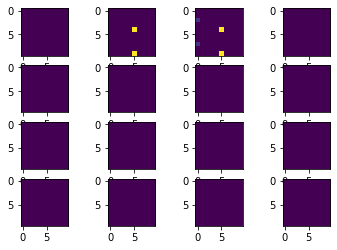

In [4]:
for a in range(num_dir):
    plt.subplot(4, 4, a+1)
    #plt.title("ReLU")
    plt.imshow(np.reshape(np.maximum(0, p_list[0][:,a]), (10,10)))

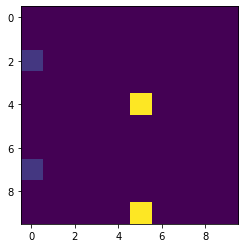

In [6]:
plt.imshow(np.reshape(np.maximum(0, p_list[0][:,2]), (10,10)))